    I am not the best coder or applied computer scientist; aside from this class, the only course I have taken that involved any sort of code-based projects was 6.036, undergrad machine learning. So my main goal for this project was get some practice with basic computer tasks involving parallel computing, so I tried to create my own graphics rendering function. There are ways to vectorize graphics so that you can have unlimited resolution, but vectors graphics are complicated enough for a graphics class, not so much for a two-week self-research project where I had to learn everything from scratch.

In [1]:
using Images, Colors, ImageCore;

First, I tried to figure out how to create basic graphics.

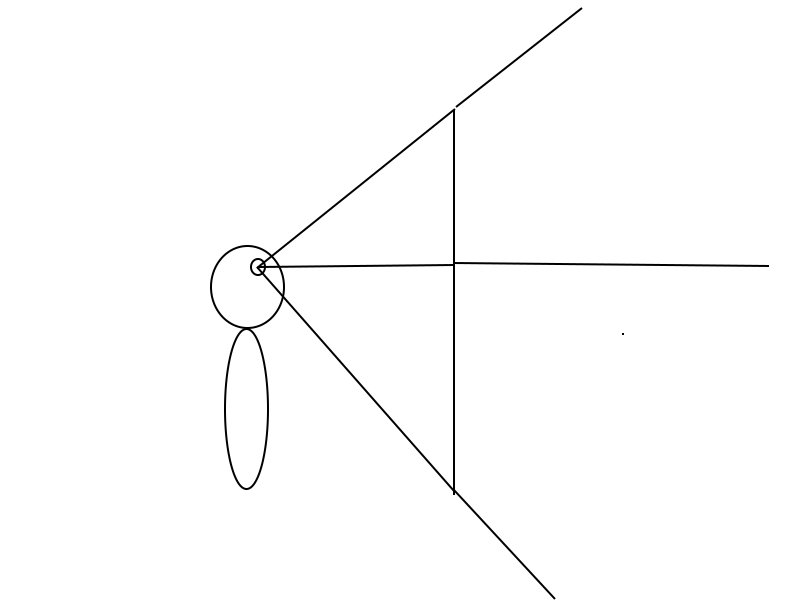

In [2]:
load("sideprojection.jpg")

In [3]:
unrotated = Array(Float64,len,hi,3)

LoadError: LoadError: UndefVarError: len not defined
while loading In[3], in expression starting on line 1

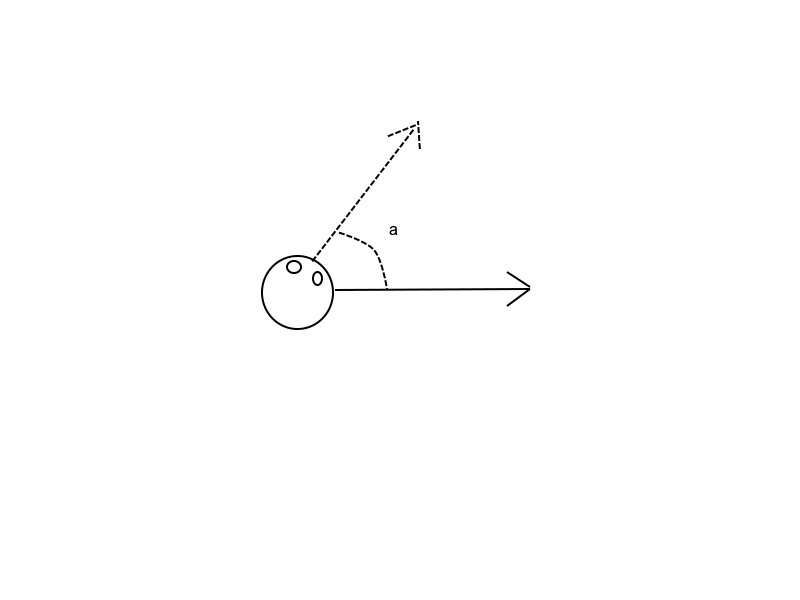

In [4]:
load("rotation.jpg")

In [5]:
for i in 1:len
    for j in 1:hi
        x = fx + (trunc(len/2)+1 - i)*sBeta*fovx/len + (trunc(hi/2)+1-j)*cBeta*(fovy*sin(alpha))/hi
        y = fy + (trunc(len/2)+1 - i)*cBeta*fovx/len + (trunc(hi/2)+1-j)*sBeta*(fovy*sin(alpha))/hi
        z = fz + (trunc(hi/2)+1-j)*(fovy*cos(alpha))/hi
        vec = [x y z]
        vectors[i,j,:] = vec
    end
end
#OR 
#Face = Vectors * RotationMaty * RotationMatz

LoadError: LoadError: UndefVarError: len not defined
while loading In[5], in expression starting on line 1

There were two ways to create my vectors that would then need to be projected: I could calculate each one individually by incrementing around some initial face vector, or I could create some standard projection field, and then just rotate it to whatever direction I wanted to be facing. Obviously, the second method is much faster, since I can pass my standard into whatever function I'm doing, and then just rotate it with matmul on whatever platform is fastest, GPU or CPU. I decided to do both, and then compare them.

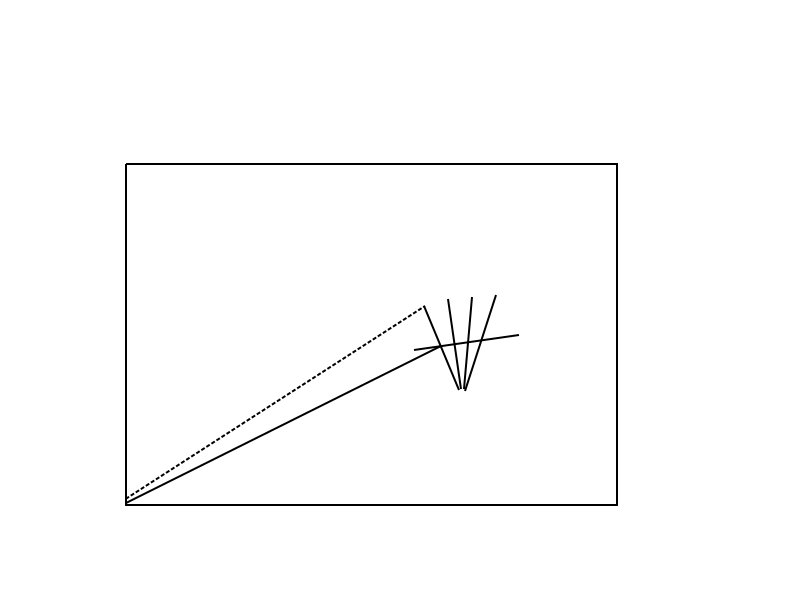

In [6]:
load("transform.jpg")

The next challenge is figuring out how to perform collison checks. There are a lot of pretty complicated algorithms and data structures that can help with this, but I decided that just querrying julia matrix objects would be fast enough for what I was really interesting with. Basically, for each vector, I wanted to increment a tiny amount, and then check to see if my new location is a wall or not.

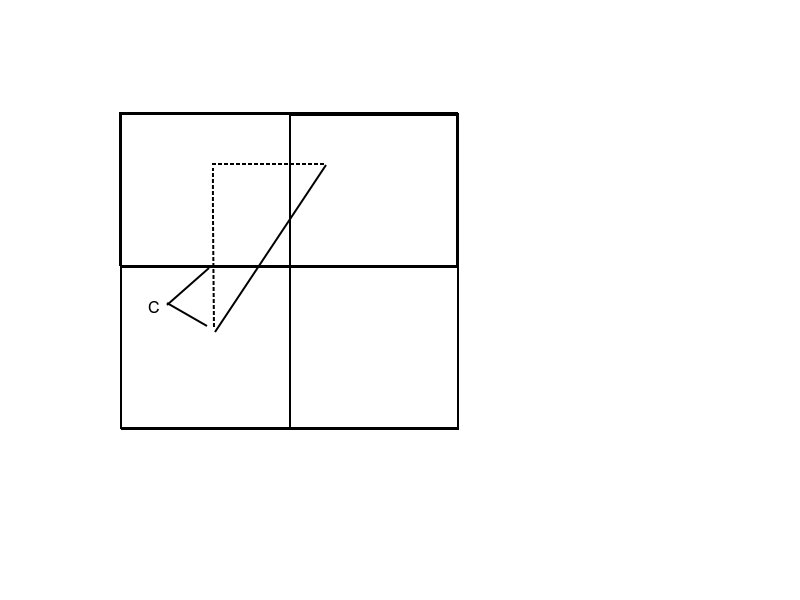

In [7]:
load("inc.jpg")

Since the world is broken into tiny square increments, I can simply check the dimensions of each vector, and see the first to pass into a new square. The ratio of the distance to the new square over the total length of the dimension becomes my c value, and I increment that much of the vector along its length to arrive at a new location.

In [8]:
projected = Array(String, 4, 4)
for i in 1:4
    for j in 1:4
        if i == j
            projected[i,i] = "1"
        else
            projected[i,j] = "0"
            projected[j,i] = "0"
        end
    end
end
projected[1,4] = "cX"
projected[2,4] = "cY"
projected[3,4] = "cZ"
projected

4×4 Array{String,2}:
 "1"  "0"  "0"  "cX"
 "0"  "1"  "0"  "cY"
 "0"  "0"  "1"  "cZ"
 "0"  "0"  "0"  "1" 

I couldn't think of way to concievably do the entire thing as a sequence of matrix multiplication problems, since each check depends on the location before it. However, I can do each step individually as a matrix multiplication problem, and could, given I knew the series of c values I would be calculating, do the entire thing.

In [9]:
current = Array(String,4,1)
current[1,1] = "px + ΣcX"
current[2,1] = "py + ΣcY"
current[3,1] = "pz + ΣcZ"
current[4,1] = "1"
current

4×1 Array{String,2}:
 "px + ΣcX"
 "py + ΣcY"
 "pz + ΣcZ"
 "1"       

Finally, I collected the color of the wall that each vector hit, and recorded it. I passed my color outputs to colorview, which processed the pixels into the image a person in that location would see.

In [10]:
work = 10
addprocs(work)
#rmprocs(collect(22:26))
procs()

11-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

I wasn't able to get ArrayFire.jl working properly on my machine...
If I had to guess why, I would say that since Nvidia doesn't make official drivers for Ubuntu or other Linux flavors, mixed with the fact that I have a GTX 1080, Nvidia's newest card, leads to having a set-up where the community made graphics drivers have not been fulling tested. My Windows machine, which I don't really understand, has daily driver updates; my linux does not.
So, most of my parrelism comes from projecting each vector on a different CPU core. It would have been fun to explore the GPU version of for loops, but I wasn't able to set myself to have that opportunity :/

In [11]:
function createWorld()
    world = Array(Float64,500,500,128,4);
    wallpic1 = load("wallpic.jpg")
    wallpixel1 = float(Array(channelview(wallpic1)))
    air = [0.0,0.0,0.0,true]
    vert = [1.0,0.0,0.0,false]
    hor = [0.0,1.0,0.0,false]
    roof = [0.0,0.0,1.0,false]
    ceiling = [.3,.3,.3,false]
    for i in (1:500)
        for j in (1:500)
            world[i,j,1,:] = roof
            for k in 2:127
                world[i,j,k,:] = air
            end
            world[i,j,128,:] = ceiling
        end
    end
    for i in (1:500)
        for j in 1:128
            world[i,1,j,:] = vert
            world[i,500,j,:] = vert
            world[1,i,j,:] = hor
            world[500,i,j,:] = hor
        end
    end
    for i in 1:300
        for j in 1:128
            world[1,i,j,:] = hor
            world[i,1,j,:] = vert
            world[500,i,j,:] = hor
            world[i,500,j,:] = vert
        end
    end
    for i in 100:100:400
        for j in 0:100
            for k in 1:128    
                world[i,j+100,k,:] = hor
                world[i,j+300,k,:] = hor        
                world[j+100,i,k,:] = vert
                world[j+300,i,k,:] = vert
            end
        end
    end
    for j in 1:500
        for i in 1:128
            world[1,j,i,:] = [wallpixel1[1,129-i,j], wallpixel1[2,129-i,j], wallpixel1[3,129-i,j], true]
        end
    end
    return world
end

createWorld (generic function with 1 method)

This is my create world function, which generates the space that I am going to place my camera in. In my single-core version, I was able to load images and place them on the walls. In my multicore, loading the image from file to put on the workers was more effort than it was worth, so I decided to just observe a bare world.

In [12]:
@everywhere function createWorldnopic()
    world = Array(Float64,500,500,128,4);
    air = [0.0,0.0,0.0,true]
    vert = [1.0,0.0,0.0,false]
    hor = [0.0,1.0,0.0,false]
    roof = [0.0,0.0,1.0,false]
    ceiling = [.3,.3,.3,false]
    for i in (1:500)
        for j in (1:500)
            world[i,j,1,:] = roof
            for k in 2:127
                world[i,j,k,:] = air
            end
            world[i,j,128,:] = ceiling
        end
    end
    for i in (1:500)
        for j in 1:128
            world[i,1,j,:] = vert
            world[i,500,j,:] = vert
            world[1,i,j,:] = hor
            world[500,i,j,:] = hor
        end
    end
    for i in 1:300
        for j in 1:128
            world[1,i,j,:] = hor
            world[i,1,j,:] = vert
            world[500,i,j,:] = hor
            world[i,500,j,:] = vert
        end
    end
    for i in 100:100:400
        for j in 0:100
            for k in 1:128    
                world[i,j+100,k,:] = hor
                world[i,j+300,k,:] = hor        
                world[j+100,i,k,:] = vert
                world[j+300,i,k,:] = vert
            end
        end
    end
    return world
end

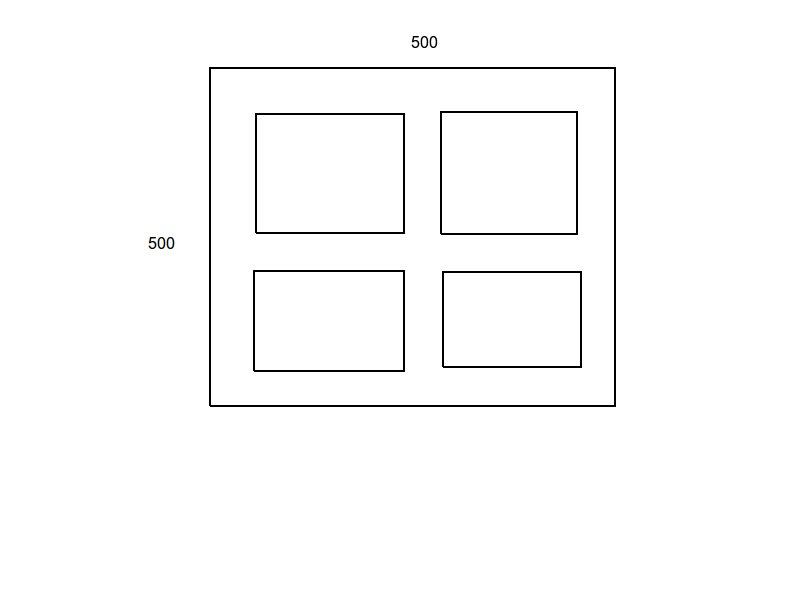

In [13]:
load("map.jpg")

This is basically what my world looks like. It is pretty easy to place images on the walls.

for i in [1:500,2501:3000]
    floor[1,i,:] = hor
    floor[501,i,:] = hor
    floor[651,i,:] = hor
    floor[1401,i,:] = hor
end
for i in [501:1950,1501:2500]
    floor[201,i,:] = hor
    floor[300,i,:] = hor
    floor[196,i,:] = hor
    floor[1050,i,:] = hor
    floor[1401,i,:] = hor
    floor[1651,i,:] = hor
    floor[2050,i,:] = hor
end
for i in [1951:1550]
    floor[200,i,:] = hor
    floor[2050,i,:] = hor
end

for i in [1:200,301:500,901:1100,1201:1650]
    floor[i,1,:] = vert
    floor[i,3000,:] = vert
    floor[i,500,:] = vert
    floor[i,2500,:] = vert
end
for i in [201:300,1100,1200]
    floor[i,1,:] = vert
    floor[i,3000,:] = vert
end
for i in [301:1100,1201:1550]
    floor[1451,i,:] = vert
    floor[1550,i,:] = vert
end
for i in [1551:2050]
    floor[501,i,:] = vert
    floor[2500,i,:] = vert
end

In [14]:
using JLD
world = createWorld();
save("/home/acwrenn/18.337_2016/Final/demo.jld", "demo", world)

In [15]:
function generateView(px,py,len,hi,fx,fy,fz,fovx,fovy,world)
    vectors = Array(Float64,len,hi,3)
    #Calculate Constants
    alpha = atan(fz/(fx^2 + fy^2)^.5)
    beta = atan(fy/fx)
    sBeta = sin(atan(fy/fx))
    cBeta = cos(atan(fy/fx))
    #Calculate Vectors; This is basically just hand-matrix-multiplication. Matmul on a GPU would be optimal
    for i in 1:len
        for j in 1:hi
            x = fx + (trunc(len/2)+1 - i)*sBeta*fovx/len + (trunc(hi/2)+1-j)*cBeta*(fovy*sin(alpha))/hi
            y = fy + (trunc(len/2)+1 - i)*cBeta*fovx/len + (trunc(hi/2)+1-j)*sBeta*(fovy*sin(alpha))/hi
            z = fz + (trunc(hi/2)+1-j)*(fovy*cos(alpha))/hi
            vec = [x y z]
            vectors[i,j,:] = vec
        end
    end
    position = [px,py,64]
    output = Array(Float64,len,hi,3)
    for i in 1:len
        for j in 1:hi
            selected = vectors[i,j,:]
            space = true
            currentLocation = position
            counter = 0
            projectedColor = [0,0,0,1]
            while space
                currents = Array(Int, 3)
                collides = Array(Int, 3)
                scores = Array(Float64, 3)
                for k in 1:3
                    currents[k] = trunc(currentLocation[k])
                    collides[k] = sign(selected[k]) + currents[k]
                    if(collides[k] == currents[k])
                        collides[k] += 1
                    end
                    if selected[k] != 0
                        scores[k] = (collides[k] - currentLocation[k])/selected[k]
                    else
                        scores[k] = 10
                    end
                end
                low = minimum(scores)
                projectedLocationfloat = Array(Float64,3)
                for k in 1:3
                    projectedLocationfloat[k] = Float64(low*selected[k] + currentLocation[k]) 
                    projectedLocationfloat[k] += .001
                end
                projectedLocation = Array(Int,3)
                for k in 1:3
                    projectedLocation[k] = trunc(projectedLocationfloat[k])
                    if k == 3
                        if projectedLocation[k] < 1
                            projectedLocation[k] = 1
                        elseif projectedLocation[k] > 128
                            projectedLocation[k] = 128
                        end
                    elseif k != 3
                        if projectedLocation[k] > 500
                            projectedLocation[k] = 500
                        elseif projectedLocation[k] < 1
                            projectedLocation[k] = 1
                        end
                    end
                    
                end 
                projectedColor = world[projectedLocation[1],projectedLocation[2],projectedLocation[3],:]
                space = (projectedColor[4] == 1)
                hitCount = false
                if counter > 1000 
                    space = false
                    hitCount = true
                end
                counter += 1
                if space
                    currentLocation = projectedLocationfloat                    
                elseif !(hitCount)
                    space = false
                end
            end
            output[i,j,1] = projectedColor[1]
            output[i,j,2] = projectedColor[2]
            output[i,j,3] = projectedColor[3]
        end
    end
    return vectors,output
end

generateView (generic function with 1 method)

In [16]:
vecs,output = generateView(50,5,481,241,0,1,0,pi/3,pi/3,world);

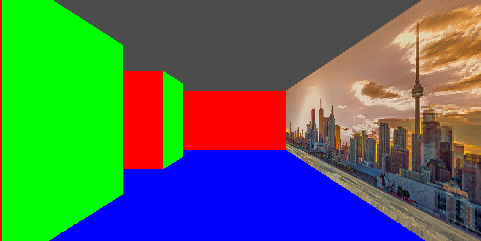

In [17]:
colorview(RGB,output[:,:,1]',output[:,:,2]',output[:,:,3]')

This is basically as terrible a version as I could make. It uses a single core to run through everything, and it creates its inital vector field from scratch every time it updates. The following code is basically a version in a lower resolution where I could input keys to walk around, but I got tired of forcing myself through them everytime I restarted the kernel so I just automated a couple steps. 

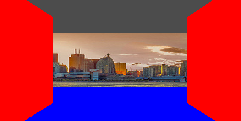

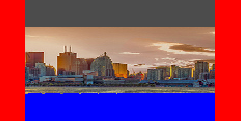

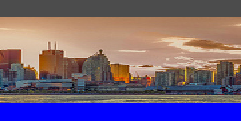

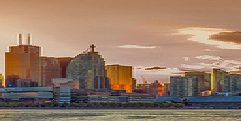

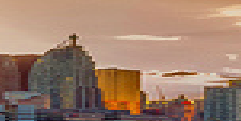

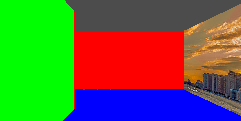

In [18]:
px,py,len,hi,fx,fy,fz,fovx,fovy = 270,250,241,121,-1,0,0,pi/3,pi/3
#key = 'h'
for key in ["w","w","w","w","d","w"]
    #while key != 'q'    
    vecs,output = generateView(px,py,len,hi,fx,fy,fz,pi/3,pi/3,world)
    colorview_o = colorview(RGB,output[:,:,1]',output[:,:,2]',output[:,:,3]')
    display(colorview_o)
    #key = readline(STDIN)
    alpha = atan(fy/fx)
    if key == "q"
        break
    elseif key == "w"
        px -= 50*cos(atan(fy/fx))
        py -= 50*sin(atan(fy/fx))
    elseif key == "s"
        px += 50*cos(atan(fy/fx))
        py += 50*sin(atan(fy/fx))
    elseif key == "a"
        ofx =fx
        fx = fx*cos(-pi/2) - fy*sin(-pi/2)
        fy = fy*cos(-pi/2) + ofx*sin(-pi/2)
    elseif key == "d"
        ofx = fx
        fx = fx*cos(pi/2) - fy*sin(pi/2)
        fy = fy*cos(pi/2) + ofx*sin(pi/2)
    end

    if world[Int(trunc(px)),Int(trunc(py)),64,4] == 0.0
        px = 250
        py = 250
    end
end

In [19]:
@time generateView(400,250,1001,501,-1,0,0,pi/3,pi/3,world)

 83.509688 seconds (4.56 G allocations: 139.812 GB, 15.01% gc time)


(
[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]

[0.523076 0.523076 … 0.523076 0.523076; 0.52203 0.52203 … 0.52203 0.52203; … ; -0.52203 -0.52203 … -0.52203 -0.52203; -0.523076 -0.523076 … -0.523076 -0.523076]

[0.522554 0.520463 … -0.520463 -0.522554; 0.522554 0.520463 … -0.520463 -0.522554; … ; 0.522554 0.520463 … -0.520463 -0.522554; 0.522554 0.520463 … -0.520463 -0.522554],

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

Obviously 80 seconds is quite slow. However, the process is performing about 2.5 million operations and none of them are operating over the same space, since two vision vectors cannot intersect.
If I were really trying to make this run fast enough to simulate vision, I would run a different version that only projects along parrallel to the ground, and then, when a vector collides with a wall, extrapolate the height of that wall based on our distance from the collision. This would get us about at least a 500x speed up, since we only project one dimension. However, I am more interested in speeding this up through parrallelization, not about creating a simulator.

In [20]:
px,py,len,hi,fx,fy,fz,fovx,fovy = 400,250,201,101,-1,0,0,pi/3,pi/3
@everywhere function vectorProject(vec,world,px,py)
    position = [px, py, 64]
    selected = vec
    space = true
    currentLocation = position
    counter = 0
    projectedColor = [0,0,0,1]
    while space
        currents = Array(Int, 3)
        collides = Array(Int, 3)
        scores = Array(Float64, 3)
        for k in 1:3
            currents[k] = trunc(currentLocation[k])
            collides[k] = sign(selected[k]) + currents[k]
            if(collides[k] == currents[k])
                collides[k] += 1
            end
            if selected[k] != 0
                scores[k] = (collides[k] - currentLocation[k])/selected[k]
            else
                scores[k] = 10
            end
        end
        low = minimum(scores)
        projectedLocationfloat = Array(Float64,3)
        for k in 1:3
            projectedLocationfloat[k] = Float64(low*selected[k] + currentLocation[k]) 
            projectedLocationfloat[k] += .001
        end
        projectedLocation = Array(Int,3)
        for k in 1:3
            projectedLocation[k] = trunc(projectedLocationfloat[k])
            if k == 3
                if projectedLocation[k] < 1
                    projectedLocation[k] = 1
                elseif projectedLocation[k] > 128
                    projectedLocation[k] = 128
                end
            elseif k != 3
                if projectedLocation[k] > 500
                    projectedLocation[k] = 500
                elseif projectedLocation[k] < 1
                    projectedLocation[k] = 1
                end
            end

        end 
        projectedColor = world[projectedLocation[1],projectedLocation[2],projectedLocation[3],:]
        space = (projectedColor[4] == 1)
        hitCount = false
        if counter > 1000 
            space = false
            hitCount = true
        end
        counter += 1
        if space
            currentLocation = projectedLocationfloat                    
        elseif !(hitCount)
            space = false
        end
    end
    return(projectedColor)
end

This code is the code that I should have function-ized earlier; basically, by passing a vector and 

In [21]:
vectors = Array(Float32,Int(len),Int(hi),3)
alpha = atan(fz/(fx^2 + fy^2)^.5)
beta = atan(fy/fx)
sBeta = sin(atan(fy/fx))
cBeta = cos(atan(fy/fx))    
if fx == 0
    sBeta = 1
    cBeta = 0
end
for i in 1:len
    for j in 1:hi
        x = fx + (trunc(len/2)+1 - i)*sBeta*fovx/len + (trunc(hi/2)+1-j)*cBeta*(fovy*sin(alpha))/hi
        y = fy + (trunc(len/2)+1 - i)*cBeta*fovx/len + (trunc(hi/2)+1-j)*sBeta*(fovy*sin(alpha))/hi
        z = fz + (trunc(hi/2)+1-j)*(fovy*cos(alpha))/hi
        vec = [x y z]
        vectors[i,j,:] = vec
    end
end
println("Vectors created")

Vectors created


In [22]:
procs()

11-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [23]:
position = [px,py,64]
output = Array(Float64,len,hi,3)
temp = Array(Float64,len*hi, 4)

worlds = []
for i in 2:6
    push!(worlds, @spawnat i createWorldnopic())
end
println("worlds made")

worlds made


In [24]:
As = []
lastsix = Array(Future,6)
counter = 1
for i in 1:len
    for j in 1:hi
        a = (j+hi*(i-1)) % 5 + 2
        push!(As,a)
        fut = @spawn vectorProject(vectors[i,j,:], fetch(worlds[a-1]), px, py)
        lastsix[a] = fut
        if a == 6
            for k in As
                col = fetch(lastsix[k]) 
                temp[counter,:] = col
                counter += 1
            end
            As = []
            last = []
        end
    end
end
println("Projections found")

Projections found


In [25]:
for i in 1:len
    for j in 1:hi
        color = temp[hi*(i-1)+j,:]
        output[i,j,1] = color[1]
        output[i,j,2] = color[2]
        output[i,j,3] = color[3]
    end
end

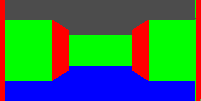

In [26]:
colorview(RGB,output[:,:,1]',output[:,:,2]',output[:,:,3]')

In [27]:
function getViewPar()
    works = 5
    px,py,len,hi,fx,fy,fz,fovx,fovy = 400,250,1001,501,-1,0,0,pi/3,pi/3
    vectors = Array(Float32,Int(len),Int(hi),3)
    alpha = atan(fz/(fx^2 + fy^2)^.5)
    beta = atan(fy/fx)
    sBeta = sin(atan(fy/fx))
    cBeta = cos(atan(fy/fx))    
    if fx == 0
        sBeta = 1
        cBeta = 0
    end
    for i in 1:len
        for j in 1:hi
            x = fx + (trunc(len/2)+1 - i)*sBeta*fovx/len + (trunc(hi/2)+1-j)*cBeta*(fovy*sin(alpha))/hi
            y = fy + (trunc(len/2)+1 - i)*cBeta*fovx/len + (trunc(hi/2)+1-j)*sBeta*(fovy*sin(alpha))/hi
            z = fz + (trunc(hi/2)+1-j)*(fovy*cos(alpha))/hi
            vec = [x y z]
            vectors[i,j,:] = vec
        end
    end
    position = [px,py,64]
    output = Array(Float64,len,hi,3)
    temp = Array(Float64,len*hi, 4)

    worlds = []
    for i in 2:works+1
        push!(worlds, @spawnat i createWorldnopic())
    end
    As = []
    lastsix = Array(Future,works+1)
    counter = 1
    As = []
    for i in 1:len
        for j in 1:hi
            a = (j+hi*(i-1)) % works + 2
            push!(As,a)
            fut = @spawnat a vectorProject(vectors[i,j,:], fetch(worlds[a-1]),px,py)
            lastsix[a] = fut
            if a == works+1
                for k in As
                    col = fetch(lastsix[k]) 
                    temp[counter,:] = col
                    counter += 1
                end
                As = []
            end
        end
    end
    for i in 1:len
        for j in 1:hi
            color = temp[hi*(i-1)+j,:]
            output[i,j,1] = color[1]
            output[i,j,2] = color[2]
            output[i,j,3] = color[3]
        end
    end
    return output
end

getViewPar (generic function with 1 method)

In [28]:
@time output = getViewPar();

1060.687223 seconds (280.29 M allocations: 8.350 GB, 0.20% gc time)


Running these vector projections over multiple cores using @spawn ended up being almost comically terrible. I don't know why the transfer costs were so high each time, but I think that using only 6 cores is a terrible idea, too many more and my computer ends up struggling. If I would have had access to the hundreds of cores on my gpu, I think that running it in parrallel would have been less costly. I think that the logic behind running it over multiple cores is sound, though, since each is totally independant of the others: Calculate the c value with 6 operations, and then project forward with one operation and an index.

If I had to guess the issue, I would guess that every iteration of @spawn where I am fetching the world map is fetching the world map to my main kernel, and then resending it back to where it originally came from. This is something that the Julia documentation claims does not happen, but I don't think that sending a 3-float vector from one core to another would cause a 10x slow down.

In [29]:
function normTest()   
    world = createWorldnopic()
    for i in 1:6
        vectorProject([1,0,0],world,1,1)
    end
end
function parTest()
    worlds = []
    for i in 2:7
        push!(worlds, @spawnat i createWorldnopic())
    end
    As = []
    lastsix = Array(Future,7)
    counter = 1
    for i in 2:7
        push!(As,i)
        fut = @spawnat i vectorProject([1,0,0], fetch(worlds[i-1]),1,1)
        lastsix[i] = fut
    end
    for j in As
        fetch(lastsix[j])
    end
end

parTest (generic function with 1 method)

In [30]:
@time normTest()

  8.368710 seconds (32.80 M allocations: 2.417 GB, 2.94% gc time)


In [31]:
@time parTest()

 18.514752 seconds (374.98 k allocations: 16.304 MB, 0.03% gc time)


This test kinda cements to me that @spawnat is moving the entire world in its fetch(worlds[i-1]) section. This boiled it down  to which is done faster: creating a world and then projecting 6 vectors, or creating a world on each kernel and then projecting once on each core. Based on my understanding, the second should be around 2/3 the time, since all world creations are done independently and should be the same as a single core, and then vector projection should be 6 times faster since each is being done at the same time. I think that, unfortunetly, we see the whole world moving before each one of the 6 vector projections, which causes a pretty massive slow down. We can also identify this issue as belonging to the vector projection stage, and not the world creation stage, since in the full version, we see a 150x slowdown, isntead of a 2x slowdown, and the main difference between the two is about 100,000 less vector projections in my test.

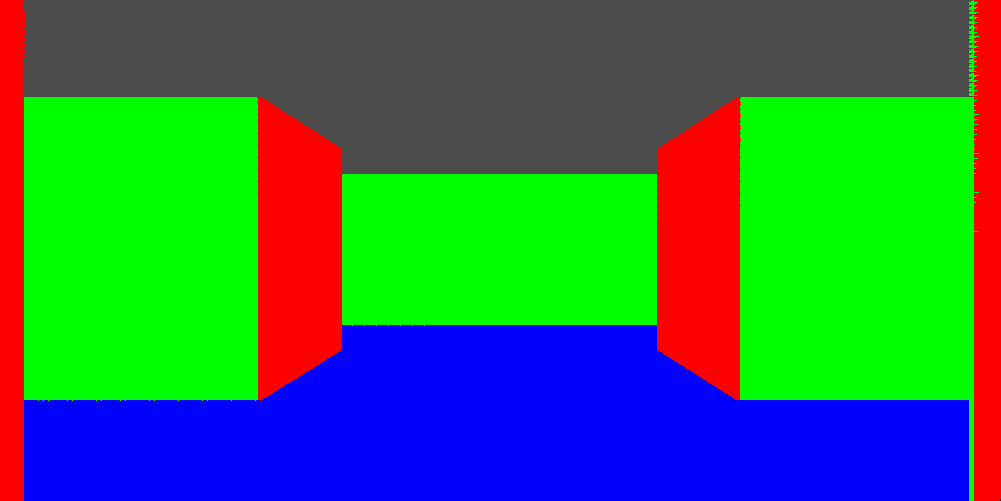

In [32]:
colorview(RGB,output[:,:,1]',output[:,:,2]',output[:,:,3]')

In [33]:
using ArrayFire

In [34]:
getActiveBackend()
setBackend(AF_BACKEND_CUDA)

CPU Backend


LoadError: LoadError: ArrayFire Error (501) : Failed to load dynamic library. 
while loading In[34], in expression starting on line 2

This is the part that isn't working, that prevented me from trying to parrallelize this algorithm over the GPU. I spent way longer than I should trying to get this figured out.

In [35]:
px,py,len,hi,fx,fy,fz,fovx,fovy = 50,5,481,241,0,1,0,pi/3,pi/3
function createStandard(len,hi,fovy,fovx)
    standard = Array(Float64,len,hi,4)
    for i in 1:len
        for j in 1:hi
            x = 1
            y = (trunc(len/2)+1 - i)*fovx/len
            z = (trunc(hi/2)+1-j)*fovy/hi
            vec = [x y z 1]
            standard[i,j,:] = vec
        end
    end
    return standard
end
afWorld = AFArray(world);

In [36]:
pVectors = Array(Float64,len*hi,4)
for i in 1:len
    for j in 1:hi
        a = hi*(i-1)+j
        pVectors[a,1] = standard[i,j,1]
        pVectors[a,2] = standard[i,j,2]
        pVectors[a,3] = standard[i,j,3]
        pVectors[a,4] = 1
    end
end
pVectors

LoadError: LoadError: UndefVarError: standard not defined
while loading In[36], in expression starting on line 2

In [37]:
thet = atan(fy/fx)
alpha = atan(fz/(fx^2 + fy^2)^.5)
RotationMat =zeros(4,4)
RotationMat[1,1] = cos(alpha)
RotationMat[1,3] = sin(alpha)
RotationMat[3,1] = -sin(alpha)
RotationMat[3,3] = cos(alpha)
RotationMat[2,2] = 1
RotationMat[1,1] = 1
RotationMat[4,4] = 1
RotationMatgpuy = AFArray(RotationMat)

RotationMat =zeros(4,4)
RotationMat[1,1] = cos(thet)
RotationMat[2,1] = sin(thet)
RotationMat[1,2] = -sin(thet)
RotationMat[2,2] = cos(thet)
RotationMat[3,3] = 1
RotationMat[4,4] = 1
RotationMatgpuz = AFArray(RotationMat)

4×4 ArrayFire.AFArray{Float64,2}:
 6.12323e-17  -1.0          0.0  0.0
 1.0           6.12323e-17  0.0  0.0
 0.0           0.0          1.0  0.0
 0.0           0.0          0.0  1.0

In [38]:
RotationMaty = Array(RotationMatgpuy)

4×4 Array{Float64,2}:
  1.0  0.0  0.0  0.0
  0.0  1.0  0.0  0.0
 -0.0  0.0  1.0  0.0
  0.0  0.0  0.0  1.0

In [39]:
RotationMatz = Array(RotationMatgpuz)

4×4 Array{Float64,2}:
 6.12323e-17  -1.0          0.0  0.0
 1.0           6.12323e-17  0.0  0.0
 0.0           0.0          1.0  0.0
 0.0           0.0          0.0  1.0

In [40]:
gpuVectors = AFArray(pVectors)
gpuFace = RotationMatgpuy * RotationMatgpuz * gpuVectors'

4×115921 ArrayFire.AFArray{Float64,2}:
 0.0          0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.3235e-316  7.39453e-316  6.3235e-316     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0           0.0             1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0          1.0           1.0             1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [41]:
face = Array(gpuFace)
Face = (RotationMaty * RotationMatz * pVectors')

4×115921 Array{Float64,2}:
 0.0          0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.3235e-316  7.39453e-316  6.3235e-316     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0           0.0             1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0          1.0           1.0             1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [42]:
function createRotMat(fx,fy,fz)
    thet = atan(fy/fx)
    if fy == 0 && fx < 0
        thet *= -1
    end
    alpha = atan(fz/(fx^2 + fy^2)^.5)
    
    RotationMaty =zeros(4,4)
    RotationMaty[1,1] = cos(alpha)
    RotationMaty[1,3] = sin(alpha)
    RotationMaty[3,1] = -sin(alpha)
    RotationMaty[3,3] = cos(alpha)
    RotationMaty[2,2] = 1
    RotationMaty[1,1] = 1
    RotationMaty[4,4] = 1
    RotationMatz=zeros(4,4)
    RotationMatz[1,1] = cos(thet)
    RotationMatz[2,1] = sin(thet)
    RotationMatz[1,2] = -sin(thet)
    RotationMatz[2,2] = cos(thet)
    RotationMatz[3,3] = 1
    RotationMatz[4,4] = 1
    return(RotationMaty,RotationMatz)
end

function getViewFinal(standards,px,py,len,hi,fx,fy,fz,fovx,fovy,world)

    RotationMaty,RotationMatz = createRotMat(fx,fy,fz)

    output = Array(Float64,len,hi,3)

    for i in 1:len
        for j in 1:hi
            tbr = standards[i,j,:]
            vec = RotationMaty*(RotationMatz*tbr)
            color = vectorProject(vec',world,px,py)
            output[i,j,1] = color[1]
            output[i,j,2] = color[2]
            output[i,j,3] = color[3]
        end
    end
    return output
end

getViewFinal (generic function with 1 method)

In [43]:
px,py,len,hi,fx,fy,fz,fovx,fovy = 20,50,1001,501,1,0,0,pi/3,pi/3
standards = createStandard(len,hi,fovy,fovx)
world = createWorld()
@time output = getViewFinal(standards,px,py,len,hi,fx,fy,fz,fovx,fovy,world);

 75.593512 seconds (3.95 G allocations: 121.498 GB, 14.15% gc time)


By replacing the vector field initialization with a rotation, we were able to shave off 1/8 of our time, which is a reasonable speed up, and end up with about 8 frames per second in a less dense projection system. We weren't able to get any sort of speed up from parralellizing it, due to the nature of needing to send a fairly large file into the kernel.

I don't know enough about how these languages work to say exactly for sure what I need. When I initiliaze something into a core, does it createa seperate copy on the memory? Does it load it into the cache for each core? I think learning more about this would really help me debug the exact chokepoint.

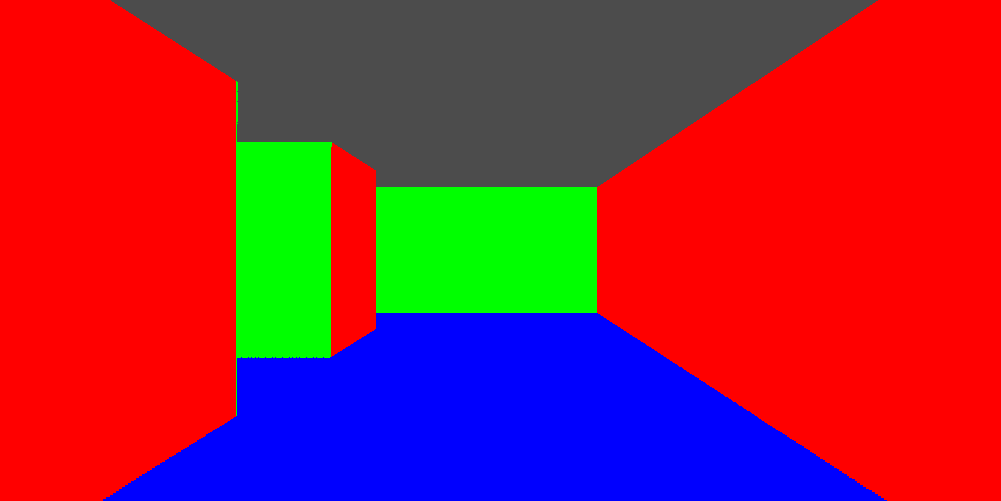

In [44]:
colorview(RGB,output[:,:,1]',output[:,:,2]',output[:,:,3]')

Things to improve on: Parallelize the vector projection; if we can estimate our c values, we can use matrix multiplication on all len x hi vectors. This type of work would be very well suited for a GPU.

Creating polygons in space in order to increase visual effects; why does the entire world need to be made of 1 x 1 x 1 cubes? Current solution is using triangles with 4 different components; a color, and three vertex locations. This allows shapes that exist in multiple dimensions.

Create Data Structures that allow us to recognize when collisions happen; not always as easy as indexing into an array

Add Lighting; once our cast rays strike a surface, project to each light source. Collision?

Add ability to collect Inputs and be able to move around the area, and find a better way to output image rather than Colorview.
